In [1]:
#TaylorGreen2D
#Energy reporten (gibt verschiedene Möglichkeiten an die Daten zu kommen)
#Dissipation ist zeitliche Ableitung (numpy.gradient)
# ins Paper schauen, wie das definiert ist
# Vis über matplotlib
# welche Reynolds sind im Paper
#die hohen Re bekommt man hier nicht hin (speicher)
#geringe Auflösung bis 100-200

In [2]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [3]:
my_data = np.genfromtxt('Brache_TGVortex_ReferenzAusLettucePaper.csv', delimiter=',')

In [4]:
def run(collision,vtk=False):
    
    ##definiere Simulationsparameter

    lattice = lt.Lattice(lt.D3Q27, device = "cuda", dtype=torch.float64)
    flow = lt.TaylorGreenVortex3D(resolution=128, reynolds_number=400, mach_number=0.05, lattice=lattice)
        #Kollisionsoperator: BGKCollision, MRTCollision, TRTCollision, RegularizedCollision, KBCCollision2D, KBCCollision3D, SmagorinskyCollision, BGKInitialization
    collision = collision(lattice, tau=flow.units.relaxation_parameter_lu)
    streaming = lt.StandardStreaming(lattice)
    simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)
    
    energy = lt.IncompressibleKineticEnergy(lattice, flow)
    simulation.reporters.append(lt.ObservableReporter(energy, interval=20,out=None))
    
    spectrum = lt.EnergySpectrum(lattice, flow)
    simulation.reporters.append(lt.ObservableReporter(spectrum, interval=int(flow.units.convert_time_to_lu(2.5)),out=None))
    
    if vtk:
        VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(0.1)), filename_base="./out")
        simulation.reporters.append(VTKreport)
        print("VTKreporter hinzugefügt")
        
    
    simulation.initialize_f_neq #zu t0 werden die Schermomente approximiert
    #am Anfang muss sich Reibung sonst erst einpendeln, so hat man aber schon einen besseren Start (insb. für schlecht aufgelöste Sim. und wichtige Sim.)
    
    print("(!)running sim with "+str(int(flow.units.convert_time_to_lu(10)))+" time steps")
    
    mlups = simulation.step(num_steps=int(flow.units.convert_time_to_lu(10)))

    energy = np.array(simulation.reporters[0].out)
    
    return energy

In [5]:
start = time.time()
print("start " + str(start))

energy_1 = run(lt.BGKCollision,vtk=False)
time1=time.time()

energy_2 = run(lt.RegularizedCollision)
time2=time.time()

energy_3 = run(lt.KBCCollision3D)
time3=time.time()

start 1668523543.9289696


/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(!)running sim with 7057 time steps
(!)running sim with 7057 time steps
(!)running sim with 7057 time steps


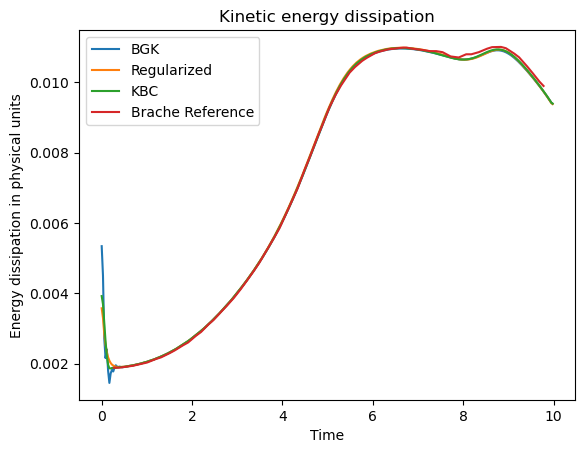

In [11]:
grad_ener1=-np.gradient(energy_1[:,2],energy_1[:,1])/((2*np.pi)**3)
grad_ener2=-np.gradient(energy_2[:,2],energy_2[:,1])/((2*np.pi)**3)
grad_ener3=-np.gradient(energy_3[:,2],energy_3[:,1])/((2*np.pi)**3)
#gradient: (f,t) -> gibt nur f'

plt.plot(energy_1[:,1],grad_ener1,'tab:blue', label='BGK')
#plt.plot(energy_1[::4,1],grad_ener1[::4],'tab:blue', label='BGK') #Energy1 oszilliert, durch Anzeige kann die Schwankung "ausgeschnitten" werden
plt.plot(energy_2[:,1],grad_ener2,'tab:orange', label='Regularized')
plt.plot(energy_3[:,1],grad_ener3,'tab:green', label='KBC')
plt.plot(my_data[:,0],my_data[:,1], 'tab:red', label='Brache Reference')
plt.legend()
plt.title('Kinetic energy dissipation')
plt.xlabel('Time')
plt.ylabel('Energy dissipation in physical units')
plt.show()

In [7]:
print("BGK_Time: "+str(time1-start))
print("Reg_Time: "+str(time2-time1))
print("KBC_Time: "+str(time3-time2))

BGK_Time: 826.6370289325714
Reg_Time: 1192.9086413383484
KBC_Time: 1671.2103304862976


In [8]:
826/60


13.766666666666667

In [9]:
1670/60

27.833333333333332